In [21]:
# Notebook for processing data from Tanya's paper in order to fill out our evaluation tables 

In [1]:
# !git clone https://github.com/princeton-nlp/LLMBar.git
from os import listdir
import pandas as pd
from datasets import Dataset
from transformers import AutoTokenizer
from statistics import mean, stdev
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from itertools import combinations
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

/u/prasanns/miniconda3/envs/rlhfenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
toker = AutoTokenizer.from_pretrained("../../models/sft10k/")

In [3]:
def convert_advdata(ex):

    ex['question'] = ex['input']
    ex['response_j'] = ex['output_'+str(ex['label'])]
    ex['response_k'] = ex['output_'+str(ex['label']%2+1)]
    ex['toks_j'] = len(toker(ex['response_j']).input_ids)
    ex['toks_k'] = len(toker(ex['response_k']).input_ids)
    return ex
    
def load_adv_dsets(base="LLMBar/Dataset/LLMBar/"):
    adfs = {}
    for s in listdir(base):
        if "." in s:
            continue
        adfs[s] = pd.read_json(base+s+"/dataset.json", orient='records')
        adfs[s] = adfs[s].apply(lambda ex: convert_advdata(ex), axis=1)
        adfs[s] = adfs[s].drop(columns=['input', 'output_1', 'output_2', 'label'])
    return adfs

adv_dsets = load_adv_dsets()

Token indices sequence length is longer than the specified maximum sequence length for this model (607 > 512). Running this sequence through the model will result in indexing errors


In [4]:
import pickle

In [5]:
# save into places that can be accessed easily
for a in adv_dsets.keys():
    Dataset.from_pandas(adv_dsets[a]).save_to_disk("../../data/adv_data/"+a)

In [6]:
# Result: Get length heuristic accuracy on these different eval sets
for k in adv_dsets.keys():
    print(k)
    tmp = adv_dsets[k]
    print("len preferred: ", tmp.toks_j.mean())
    print("len dispreferred: ", tmp.toks_k.mean())
    print("lheur: ", len(tmp[tmp.toks_j>tmp.toks_k])/len(tmp))

Natural
len preferred:  77.39
len dispreferred:  67.79
lheur:  0.57
Manual
len preferred:  117.95652173913044
len dispreferred:  222.52173913043478
lheur:  0.1956521739130435
Neighbor
len preferred:  45.75373134328358
len dispreferred:  148.03731343283582
lheur:  0.09701492537313433
GPTOut
len preferred:  63.787234042553195
len dispreferred:  68.36170212765957
lheur:  0.5106382978723404
GPTInst
len preferred:  133.7608695652174
len dispreferred:  341.0108695652174
lheur:  0.13043478260869565


In [5]:
# load in all the json files from adversarial sets
advbase = "../../outputs/evalpickles/"
# advbase = "../../outputs/ppocontrast/"
# advbase = "../../outputs/ultrarmscos/"
advfiles = {}
clearkeys = {
    'tulu-2-7b':"tulu_7b", 
    'tulu-2-13b':"tulu_13b", 
    'tulu-2-70b':"tulu_70b", 
    'tulu-2-dpo-7b':"tulu_7b-dpo", 
    'tulu-2-dpo-13b':"tulu_13b-dpo", 
    'tulu-2-dpo-70b':"tulu_70b-dpo", 
    'ultrarmv1':"RM-7b", 
    'bigmag':"RM-13b", 
}
for s in listdir(advbase):
    newkey = s
    for c in clearkeys.keys():
        if c in newkey: 
            newkey = newkey.replace(c, clearkeys[c])
    if "." not in s:
        advfiles[newkey] = pd.read_json(advbase+s, lines=True, orient='records')
        if 'tulu' in s or 'ppo' in s or 'sft' in s: 
            #print(advfiles.keys())
            advfiles[newkey]['meanrew_j'] = advfiles[newkey]['dpo_j']
            advfiles[newkey]['meanrew_k'] = advfiles[newkey]['dpo_k']
            advfiles[newkey]['rewards_j'] = [sum(st) for st in advfiles[newkey]['lls_j']]
            advfiles[newkey]['rewards_k'] = [sum(st) for st in advfiles[newkey]['lls_k']]
        #print(newkey)
        advfiles[newkey]['rdiff'] = advfiles[newkey]['rewards_j'] - advfiles[newkey]['rewards_k']

# DPO losses need to get re-formed w.r.t their sft thing
for c in advfiles.keys():
    if 'dpo' in c: 
        print(c)
        # store sum as another thing
        advfiles[c]['sumrew_j'] = advfiles[c]['rewards_j']
        advfiles[c]['sumrew_k'] = advfiles[c]['rewards_k']
        # store normalized as another thing
        advfiles[c]['rewards_j'] = advfiles[c]['rewards_j']*-1 / advfiles[c.replace("-dpo", "")]['rewards_j']
        advfiles[c]['rewards_k'] = advfiles[c]['rewards_k']*-1 / advfiles[c.replace("-dpo", "")]['rewards_k']
        advfiles[c]['sumdiff'] = advfiles[c]['sumrew_j'] - advfiles[c]['sumrew_k']
        advfiles[c]['meandiff'] = advfiles[c]['meanrew_j'] - advfiles[c]['meanrew_k']
        advfiles[c]['rdiff'] = advfiles[c]['rewards_j'] - advfiles[c]['rewards_k']

tulu_7b-dpo_Natural
tulu_7b-dpo_Manual
tulu_7b-dpo_Neighbor
tulu_7b-dpo_GPTOut
tulu_7b-dpo_GPTInst
tulu_13b-dpo_Natural
tulu_13b-dpo_Manual
tulu_13b-dpo_Neighbor
tulu_13b-dpo_GPTOut
tulu_13b-dpo_GPTInst
tulu_70b-dpo_Natural
tulu_70b-dpo_Manual
tulu_70b-dpo_Neighbor
tulu_70b-dpo_GPTOut
tulu_70b-dpo_GPTInst


In [6]:
advfiles.keys()

dict_keys(['RM-7b_Natural', 'RM-7b_Manual', 'RM-7b_Neighbor', 'RM-7b_GPTOut', 'RM-7b_GPTInst', 'RM-13b_Natural', 'RM-13b_Manual', 'RM-13b_Neighbor', 'RM-13b_GPTOut', 'RM-13b_GPTInst', 'tulu_7b-dpo_Natural', 'tulu_7b-dpo_Manual', 'tulu_7b-dpo_Neighbor', 'tulu_7b-dpo_GPTOut', 'tulu_7b-dpo_GPTInst', 'tulu_7b_Natural', 'tulu_7b_Manual', 'tulu_7b_Neighbor', 'tulu_7b_GPTOut', 'tulu_7b_GPTInst', 'tulu_13b-dpo_Natural', 'tulu_13b-dpo_Manual', 'tulu_13b-dpo_Neighbor', 'tulu_13b-dpo_GPTOut', 'tulu_13b-dpo_GPTInst', 'tulu_70b-dpo_Natural', 'tulu_70b-dpo_Manual', 'tulu_70b-dpo_Neighbor', 'tulu_70b-dpo_GPTOut', 'tulu_70b-dpo_GPTInst', 'tulu_13b_Natural', 'tulu_13b_Manual', 'tulu_13b_Neighbor', 'tulu_13b_GPTOut', 'tulu_13b_GPTInst', 'tulu_70b_Natural', 'tulu_70b_Manual', 'tulu_70b_Neighbor', 'tulu_70b_GPTOut', 'tulu_70b_GPTInst', 'checkpoints_Natural', 'checkpoints_Manual', 'checkpoints_Neighbor', 'checkpoints_GPTOut', 'checkpoints_GPTInst'])

In [7]:
key = 'tulu_13b-dpo_Natural'
len(advfiles[key][advfiles[key].rdiff>0])/len(advfiles[key])

0.7473684210526316

In [41]:
# given 2 distributions, put them into a common df
def comb_dists(d1, d2, set): 
    set1 = advfiles[d1+"_"+set]
    set2 = advfiles[d2+"_"+set]
    set1['rdiff2'] = set2['rdiff']
    return set1

def print_dists(tmpdf, d1, d2):
    for i, r in tmpdf.iterrows():
        #print(r)
        print("_______________")
        print('confidence of '+d1+': '+str(r['rdiff']))
        print('confidence of '+d2+': '+str(r['rdiff2']))
        print("QUESTION: \n", r['reponse_j'].split("\n\nAnswer:")[0])
        print("PREFERRED Answer: \n", r['reponse_j'].split("\n\nAnswer:")[1])
        print("DISPREFERRED Answer: \n", r['reponse_k'].split("\n\nAnswer:")[1])

In [46]:
s1 = 'RM-7b'
s2 = 'tulu_7b-dpo'
combo = comb_dists(s1, s2, "Natural")

In [ ]:
tmp = combo[(combo.rdiff>2) & (combo.rdiff2<-0.03)]
print_dists(tmp, s1 ,s2)

In [50]:
def prepdata(df):
    # Assuming df is your original DataFrame
    original_df = df.copy()
    
    # Create inverse dataset
    inverse_df = original_df.copy()
    inverse_df['sumdiff'] = -1*inverse_df['sumdiff']/597
    inverse_df['meandiff'] = -1*inverse_df['meandiff']/2.9
    inverse_df['rdiff'] = -1*inverse_df['rdiff']/.15
    
    # Combine and shuffle datasets
    combined_df = pd.concat([original_df, inverse_df])
    
    # Create labels
    combined_df['label'] = [1] * len(original_df) + [0] * len(inverse_df)

    combined_df = combined_df.sample(frac=1, random_state=42)
    labels = combined_df['label']
    return combined_df.drop(columns=['label']), labels

# train a linear classifier on the 3 DPO features to get a better classification model
X_train, y_train = prepdata(advfiles['tulu_7b-dpo_Natural'][['sumdiff', 'meandiff', 'rdiff']])
X_test, y_test = prepdata(advfiles['tulu_7b-dpo_Natural'][['sumdiff', 'meandiff', 'rdiff']])

# Training the model
model = LogisticRegression(max_iter=100000,penalty='none', solver='newton-cholesky', C=100)
model.fit(X_train, y_train)

# Evaluating the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

# Extracting the weights
weights = model.coef_
print("Model Accuracy:", accuracy)
print("Feature Weights:", weights)

Model Accuracy: 0.631578947368421
Feature Weights: [[0.0050773  0.49379619 2.25140448]]


/u/prasanns/miniconda3/envs/rlhfenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/u/prasanns/miniconda3/envs/rlhfenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


In [100]:
X_train['label'] = y_train

In [107]:
((X_train['rdiff']+X_train['sumdiff']*.0+X_train['meandiff']*.001>0).astype(int)==X_train['label']).astype(int).mean()

0.6526315789473685

In [42]:
X_train['sumdiff'].max()

597.3947240192003

In [8]:
showmarg = False
for k in advfiles.keys():
    print(k)
    tmp = advfiles[k]
    #print("len preferred: ", tmp.toks_j.mean())
    #print("len dispreferred: ", tmp.toks_k.mean())
    if "dpo" in k or "checkpoints" in k:
        print("accuracy: ", len(tmp[tmp.rewards_j>tmp.rewards_k])/len(tmp))
    if showmarg:
        print("margin mean: ", mean(tmp.rewards_j-tmp.rewards_k))
        print("margin std: ", stdev(tmp.rewards_j-tmp.rewards_k))

RM-7b_Natural
RM-7b_Manual
RM-7b_Neighbor
RM-7b_GPTOut
RM-7b_GPTInst
RM-13b_Natural
RM-13b_Manual
RM-13b_Neighbor
RM-13b_GPTOut
RM-13b_GPTInst
tulu_7b-dpo_Natural
accuracy:  0.6526315789473685
tulu_7b-dpo_Manual
accuracy:  0.4
tulu_7b-dpo_Neighbor
accuracy:  0.4838709677419355
tulu_7b-dpo_GPTOut
accuracy:  0.44680851063829785
tulu_7b-dpo_GPTInst
accuracy:  0.22033898305084745
tulu_7b_Natural
tulu_7b_Manual
tulu_7b_Neighbor
tulu_7b_GPTOut
tulu_7b_GPTInst
tulu_13b-dpo_Natural
accuracy:  0.7473684210526316
tulu_13b-dpo_Manual
accuracy:  0.425
tulu_13b-dpo_Neighbor
accuracy:  0.4435483870967742
tulu_13b-dpo_GPTOut
accuracy:  0.5319148936170213
tulu_13b-dpo_GPTInst
accuracy:  0.288135593220339
tulu_70b-dpo_Natural
accuracy:  0.6736842105263158
tulu_70b-dpo_Manual
accuracy:  0.425
tulu_70b-dpo_Neighbor
accuracy:  0.4435483870967742
tulu_70b-dpo_GPTOut
accuracy:  0.5957446808510638
tulu_70b-dpo_GPTInst
accuracy:  0.288135593220339
tulu_13b_Natural
tulu_13b_Manual
tulu_13b_Neighbor
tulu_13b_GP

In [113]:
ks = ['sft10k', 'ultrappostep_25', 'ultrappostep_50', 'ultrappostep_75', 'ultrappostep_100']
sets = ["Natural", "Manual", "GPTOut", "Neighbor", "GPTInst"]
def acclines():
    covals = {}
    for k in sets:
        covals[k] = []
        for u in ks:
            tmp = advfiles[u+"_"+k]
            covals[k].append(len(tmp[tmp.rewards_j>tmp.rewards_k])/len(tmp))
    return covals

def comp_plot():
    cdists = acclines()
    baselines = {
        'Natural':.705,
        "Manual":.25,
        "GPTOut":.319,
        "Neighbor":.435,
        "GPTInst":.305
    }
    x = [0, 25, 50, 75, 100]
    # Set up a color cycle (optional, for consistent colors)
    colors = plt.cm.viridis(np.linspace(0, 1, len(cdists)))
    
    # Plot each line and its baseline
    for (key, color) in zip(cdists, colors):
        # Plot line
        plt.plot(x, cdists[key], label=key, color=color)
        # Plot baseline
        if key in baselines:
            plt.axhline(y=baselines[key], color=color, linestyle='dotted')

    
    # Adding labels and title
    plt.xlabel('Train Steps')
    plt.ylabel('Mean Spearman Correlation')
    plt.title('Contast set likelihood accs over PPO:')
    plt.legend()
    
    # Show the plot
    plt.show()

In [114]:
comp_plot()

KeyError: 'sft10k_Natural'

In [117]:
advfiles.keys()

dict_keys(['RM-7b_Natural', 'RM-7b_Manual', 'RM-7b_Neighbor', 'RM-7b_GPTOut', 'RM-7b_GPTInst', 'RM-13b_Natural', 'RM-13b_Manual', 'RM-13b_Neighbor', 'RM-13b_GPTOut', 'RM-13b_GPTInst', 'tulu_7b-dpo_Natural', 'tulu_7b-dpo_Manual', 'tulu_7b-dpo_Neighbor', 'tulu_7b-dpo_GPTOut', 'tulu_7b-dpo_GPTInst', 'tulu_7b_Natural', 'tulu_7b_Manual', 'tulu_7b_Neighbor', 'tulu_7b_GPTOut', 'tulu_7b_GPTInst', 'tulu_13b-dpo_Natural', 'tulu_13b-dpo_Manual', 'tulu_13b-dpo_Neighbor', 'tulu_13b-dpo_GPTOut', 'tulu_13b-dpo_GPTInst', 'tulu_70b-dpo_Natural', 'tulu_70b-dpo_Manual', 'tulu_70b-dpo_Neighbor', 'tulu_70b-dpo_GPTOut', 'tulu_70b-dpo_GPTInst', 'tulu_13b_Natural', 'tulu_13b_Manual', 'tulu_13b_Neighbor', 'tulu_13b_GPTOut', 'tulu_13b_GPTInst', 'tulu_70b_Natural', 'tulu_70b_Manual', 'tulu_70b_Neighbor', 'tulu_70b_GPTOut', 'tulu_70b_GPTInst'])

(array([ 3.,  3.,  5., 13., 29., 19., 16.,  3.,  1.,  3.]),
 array([-0.10799954, -0.08132097, -0.05464241, -0.02796384, -0.00128527,
         0.02539329,  0.05207186,  0.07875042,  0.10542899,  0.13210755,
         0.15878612]),
 <BarContainer object of 10 artists>)

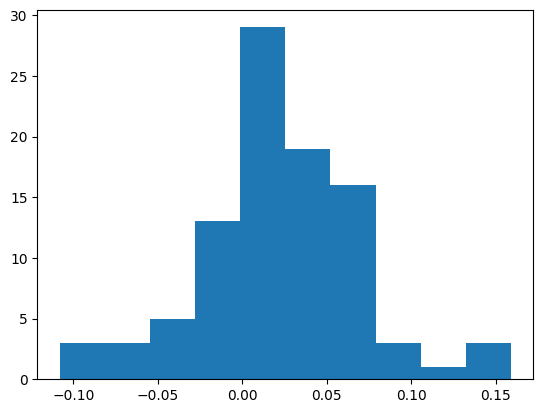

In [141]:
plt.hist(advfiles[dpo+set]['rdiff'])

Text(0.5, 1.0, 'Confidence of: RM-7b vs. RM-13b')

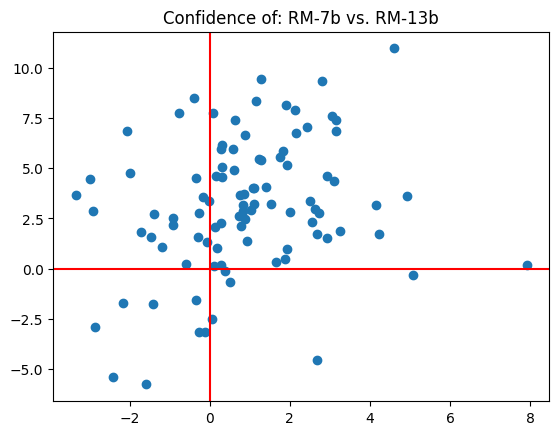

In [151]:
rm = 'RM-7b'
dpo = 'RM-13b'
set = "_Natural"
plt.scatter(advfiles[rm+set]['rdiff'], advfiles[dpo+set]['rdiff'])
plt.axhline(c='r')
plt.axvline(c='r')
plt.title("Confidence of: "+rm+" vs. "+dpo)

In [115]:
# version of code that gets plots
showmarg = False
for k in advfiles.keys():
    print(k)
    tmp = advfiles[k]
    #print("len preferred: ", tmp.toks_j.mean())
    #print("len dispreferred: ", tmp.toks_k.mean())
    print("accuracy: ", len(tmp[tmp.rewards_j>tmp.rewards_k])/len(tmp))
    if showmarg:
        print("margin mean: ", mean(tmp.rewards_j-tmp.rewards_k))
        print("margin std: ", stdev(tmp.rewards_j-tmp.rewards_k))

RM-7b_Natural
accuracy:  0.7052631578947368
RM-7b_Manual
accuracy:  0.25
RM-7b_Neighbor
accuracy:  0.43548387096774194
RM-7b_GPTOut
accuracy:  0.3191489361702128
RM-7b_GPTInst
accuracy:  0.3050847457627119
RM-13b_Natural
accuracy:  0.8631578947368421
RM-13b_Manual
accuracy:  0.4
RM-13b_Neighbor
accuracy:  0.4596774193548387
RM-13b_GPTOut
accuracy:  0.5957446808510638
RM-13b_GPTInst
accuracy:  0.5084745762711864
tulu_7b-dpo_Natural
accuracy:  0.6526315789473685
tulu_7b-dpo_Manual
accuracy:  0.4
tulu_7b-dpo_Neighbor
accuracy:  0.4838709677419355
tulu_7b-dpo_GPTOut
accuracy:  0.44680851063829785
tulu_7b-dpo_GPTInst
accuracy:  0.22033898305084745
tulu_7b_Natural
accuracy:  0.5684210526315789
tulu_7b_Manual
accuracy:  0.775
tulu_7b_Neighbor
accuracy:  0.8629032258064516
tulu_7b_GPTOut
accuracy:  0.48936170212765956
tulu_7b_GPTInst
accuracy:  0.8135593220338984
tulu_13b-dpo_Natural
accuracy:  0.7473684210526316
tulu_13b-dpo_Manual
accuracy:  0.425
tulu_13b-dpo_Neighbor
accuracy:  0.443548387

In [13]:
# figure out overlap in middle, left or rightmost n% of examples across 2 sets
def n_percent_indices(lst, n, portion, givelen=True):
        sorted_indices = sorted(range(len(lst)), key=lambda i: lst[i])
        start, end = 0, len(lst)
        length = int(len(lst) * n / 100)

        if portion == 'mid':
            start = (len(lst) - length) // 2
            end = start + length
        elif portion == 'left':
            end = length
        elif portion == 'right':
            start = len(lst) - length
        if givelen:
            return set(sorted_indices[start:end]), length
        return set(sorted_indices[start:end])
    
def compute_overlap(a, b, n, portion):
    assert len(a) == len(b)

    indices_a, l = n_percent_indices(a, n, portion)
    indices_b, l = n_percent_indices(b, n, portion)

    # Find the overlap
    overlap = indices_a.intersection(indices_b)
    
    return len(overlap) / l

def overlap_mat(files, setname="Natural", n=10, portion='mid'):
    usekeys = set([l for l in files.keys() if setname in l])
    # Initialize an empty matrix for storing overlaps
    overlap_matrix = np.zeros((len(usekeys), len(usekeys)))
    
    # Compute overlap for each pair and fill the matrix
    for i, key_i in enumerate(usekeys):
        for j, key_j in enumerate(usekeys):
            if i != j:
                overlap = compute_overlap(files[key_i]['rdiff'], files[key_j]['rdiff'], n, portion)
                overlap_matrix[i, j] = overlap
            else:
                overlap_matrix[i, j] = 1  # Assuming full overlap for the same list
    keyvals = [u.replace("_"+setname, "") for u in usekeys]
    # Plotting the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(overlap_matrix, annot=True, cmap='coolwarm', xticklabels=keyvals, yticklabels=keyvals)
    plt.title("Overlap Heatmap for "+setname+" on "+portion+" "+str(n)+"%")
    plt.show()

def find_common_overlaps(data_dict, setname="Natural", n=10, portion='mid'):
    usekeys = set([l for l in data_dict.keys() if setname in l])
    # Calculate overlapping indices for each pair

    # Step 1: Compute n% indices for all keys
    key_indices = {key: n_percent_indices(data_dict[key]['rdiff'], n, portion, False) for key in usekeys}

    for k in usekeys:
        assert len(data_dict[k])==len(data_dict[list(usekeys)[0]])
        
    # Step 2: Track set for each index
    index_sets = {}
    for index in range(max(len(lst) for lst in data_dict.values())):
        index_sets[index] = frozenset(key for key, indices in key_indices.items() if index in indices)

    #print(index_sets)
    # Step 3: Create an inverted index
    inverted_index = {}
    for index, key_set in index_sets.items():
        if key_set not in inverted_index:
            inverted_index[key_set] = []
        inverted_index[key_set].append(index)

    return inverted_index

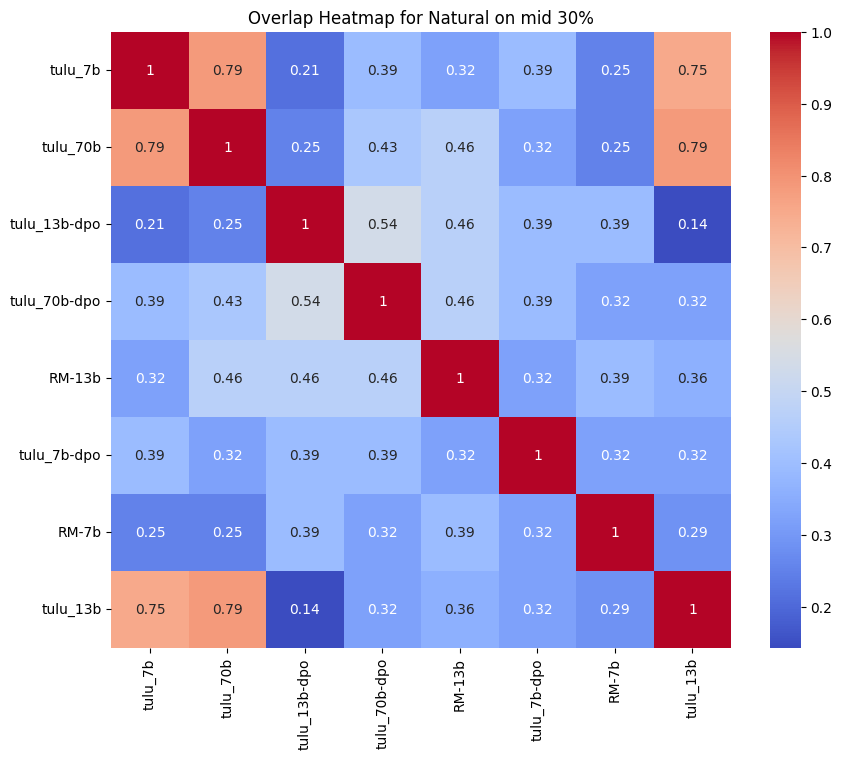

In [14]:
overlap_mat(advfiles, "Natural", 30, 'mid')
#overset = find_common_overlaps(advfiles, "Natural", 30, 'right')
#print(overset)

In [121]:
ind = 90
sj = advfiles['RM-13b_Natural'].loc[ind]['reponse_j']
print(sj[:sj.index("Answer:")])
print("response_j")
print(sj[sj.index("Answer:"):])
print('response_k')
print(advfiles['RM-13b_Natural'].loc[ind]['reponse_k'][sj.index("Answer:"):])
print(advfiles['tulu_13b-dpo_Natural'].loc[ind]['rdiff'])

Question: Rewrite the given sentence using a variety of grammar, punctuation, and structure: the woman ran quickly


response_j
Answer: Swift-footed, she darted onward.
response_k
Answer: She ran quickly.
0.7404437223999993


In [16]:
advfiles.keys()

dict_keys(['ultrarmv1_Natural', 'ultrarmv1_Manual', 'ultrarmv1_Neighbor', 'ultrarmv1_GPTOut', 'ultrarmv1_GPTInst', 'bigmag_Natural', 'bigmag_Manual', 'bigmag_Neighbor', 'bigmag_GPTOut', 'bigmag_GPTInst', 'tulu-2-dpo-7b_Natural', 'tulu-2-dpo-7b_Manual', 'tulu-2-dpo-7b_Neighbor', 'tulu-2-dpo-7b_GPTOut', 'tulu-2-dpo-7b_GPTInst', 'tulu-2-7b_Natural', 'tulu-2-7b_Manual', 'tulu-2-7b_Neighbor', 'tulu-2-7b_GPTOut', 'tulu-2-7b_GPTInst', 'tulu-2-dpo-13b_Natural', 'tulu-2-dpo-13b_Manual', 'tulu-2-dpo-13b_Neighbor', 'tulu-2-dpo-13b_GPTOut', 'tulu-2-dpo-13b_GPTInst', 'tulu-2-dpo-70b_Natural', 'tulu-2-dpo-70b_Manual', 'tulu-2-dpo-70b_Neighbor', 'tulu-2-dpo-70b_GPTOut', 'tulu-2-dpo-70b_GPTInst'])

(array([ 2.,  1.,  8., 18., 23., 43., 21.,  5.,  1.,  2.]),
 array([-4.20160004, -3.53388002, -2.86616001, -2.19843999, -1.53071997,
        -0.86299996, -0.19527994,  0.47244008,  1.14016009,  1.80788011,
         2.47560013]),
 <BarContainer object of 10 artists>)

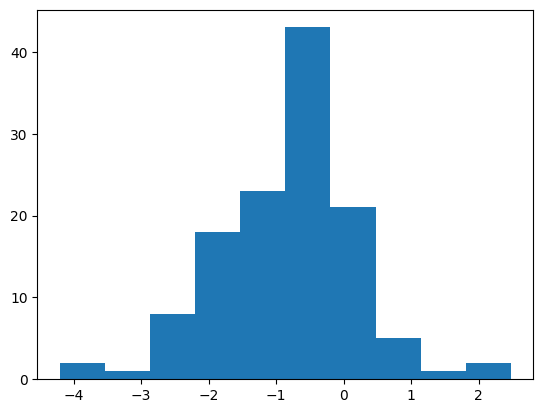

In [31]:
tmp = advfiles['tulu-2-7b_Neighbor']
plt.hist(tmp.rewards_j - tmp.rewards_k)